In [37]:
%matplotlib inline

In [38]:
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
import torch 
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils 
import PIL.Image as img
import random as rd

In [39]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

In [40]:
transform=transforms.Compose([     
                                   transforms.Scale(32),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                               ])

In [41]:
dem_data = torchvision.datasets.ImageFolder(root='./data/DEM-300m-normed-test/',transform=transform)
data_loader = torch.utils.data.DataLoader(dem_data,
                                          batch_size=64,
                                          shuffle=True)

In [42]:
def imshow(img):
    img = img / 2.0 + 0.5      # unnormalize
    npimg = img.cpu().numpy()
#     print npimg
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     print npimg

In [43]:
dataiter = iter(data_loader)
# print dataiter
images, labels = dataiter.next()

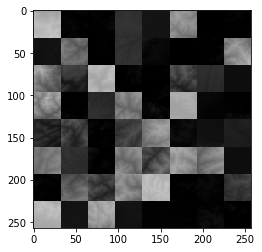

In [44]:
batch_s=images.size(0)
'''print images/2.0+0.5#第一个batchitem的第一个通道(0,0)'''
imshow(torchvision.utils.make_grid(images,nrow=8,padding=0,pad_value=0))
# vutils.save_image(images.data,'./pics/_1-uniform_dem.png',normalize=True)
# plt.savefig('./_samples.png', dpi=300) #,放大save

## reverse-normalization to construct the DEM suface

In [45]:
dems = torch.FloatTensor(images.size(0), 1, images.size(2),images.size(3)) # real data for D
dems=Variable(dems)
dems=dems.cuda()
dems.data.copy_(images[:,0,:,:])
#imshow(torchvision.utils.make_grid(dems.data))
print dems
vutils.save_image(dems.data,'./pics/_1-uniform_dem.png',normalize=True,padding=1)
vutils.save_image(dems.data,'./pics/_2-random_dem.png',normalize=True,padding=1)

Variable containing:
(0 ,0 ,.,.) = 
  0.2863  0.3020  0.3098  ...   0.2706  0.2627  0.2706
  0.3176  0.3412  0.3490  ...   0.2784  0.2941  0.2941
  0.3569  0.3882  0.3725  ...   0.3020  0.3176  0.3176
           ...             ⋱             ...          
  0.4510  0.4745  0.4824  ...   0.5059  0.4824  0.4667
  0.4824  0.4902  0.4902  ...   0.5216  0.4980  0.4824
  0.5137  0.5216  0.5059  ...   0.5137  0.4902  0.4745
     ⋮ 

(1 ,0 ,.,.) = 
 -1.0000 -1.0000 -0.9922  ...  -0.9686 -0.9608 -0.9686
 -0.9922 -0.9922 -0.9922  ...  -0.9765 -0.9686 -0.9686
 -0.9922 -0.9922 -0.9922  ...  -0.9686 -0.9765 -0.9765
           ...             ⋱             ...          
 -0.9922 -0.9922 -0.9922  ...  -0.9529 -0.9686 -0.9686
 -0.9922 -0.9922 -0.9843  ...  -0.9608 -0.9608 -0.9765
 -0.9922 -0.9922 -0.9922  ...  -0.9608 -0.9765 -0.9765
     ⋮ 

(2 ,0 ,.,.) = 
 -0.9922 -0.9843 -0.9765  ...  -0.9922 -0.9922 -0.9922
 -0.9922 -0.9843 -0.9686  ...  -0.9922 -0.9922 -0.9922
 -0.9922 -0.9922 -0.9843  ...  -0.99

/home/patrick/anaconda2/envs/deeplearning/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  after removing the cwd from sys.path.


IOError: [Errno 2] No such file or directory: './pics/_1-uniform_dem.png'

In [47]:
nc=1
ncp=100

# CPLAYER 与 CPVector

Variable containing:
(0 ,0 ,.,.) = 
  0.2863  0.3020  0.3098  ...   0.2706  0.2627  0.2706
  0.3176  0.3412  0.3490  ...   0.2784  0.2941  0.2941
  0.3569  0.3882  0.3725  ...   0.3020  0.3176  0.3176
           ...             ⋱             ...          
  0.4510  0.4745  0.4824  ...   0.5059  0.4824  0.4667
  0.4824  0.4902  0.4902  ...   0.5216  0.4980  0.4824
  0.5137  0.5216  0.5059  ...   0.5137  0.4902  0.4745
     ⋮ 

(1 ,0 ,.,.) = 
 -1.0000 -1.0000 -0.9922  ...  -0.9686 -0.9608 -0.9686
 -0.9922 -0.9922 -0.9922  ...  -0.9765 -0.9686 -0.9686
 -0.9922 -0.9922 -0.9922  ...  -0.9686 -0.9765 -0.9765
           ...             ⋱             ...          
 -0.9922 -0.9922 -0.9922  ...  -0.9529 -0.9686 -0.9686
 -0.9922 -0.9922 -0.9843  ...  -0.9608 -0.9608 -0.9765
 -0.9922 -0.9922 -0.9922  ...  -0.9608 -0.9765 -0.9765
     ⋮ 

(2 ,0 ,.,.) = 
 -0.9922 -0.9843 -0.9765  ...  -0.9922 -0.9922 -0.9922
 -0.9922 -0.9843 -0.9686  ...  -0.9922 -0.9922 -0.9922
 -0.9922 -0.9922 -0.9843  ...  -0.99

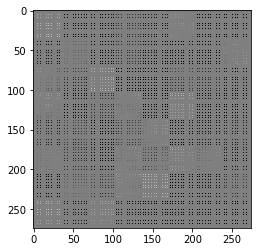

In [49]:
'''def chooseControlPoints(dems):
    cp=[]
    for n in range(0,batch_s):
        cp.append([])
        for i in range(0,ncp):
            cp[n].append([dems[n,0,i,i],i,i])# extract dem control point function
    return cp'''
imageSize=32
'''
def ControlPointsImage(dems,ncp,y_cpLayer):
    cp=[]
    x_index=[]
    y_index=[]
    step=np.floor(imageSize/np.sqrt(ncp))    
    pad=imageSize%np.floor(np.sqrt(ncp))
    #print step,pad
    for i in range(0,int(np.floor(np.sqrt(ncp)))):
        x_index.append(pad+i*step)
        y_index.append(pad+i*step)
    for n in range(0,batch_s):
        cp.append([])
        for i in x_index:
            for j in y_index:
                cp[n].append([dems[n,0,i,j],i,j])# extract dem control point function
    for i in range(0,batch_s): 
        for _cp in cp[i]:
            h=_cp[0]
            x=_cp[1]
            y=_cp[2]
            y_cpLayer[i,0,x,y]=h
    return y_cpLayer
'''
def ControlPointsImage(dems,ncp,y_cpLayer):
    cp=[]
    x_index=[]
    y_index=[]
    step=float((imageSize-1)/(np.sqrt(ncp)-1))
    #print step,pad
    for i in range(0,int(np.floor(np.sqrt(ncp)))):
        x_index.append(i*step)
        y_index.append(i*step)
    for n in range(0,batch_s):
        cp.append([])
        for i in x_index:
            for j in y_index:
                cp[n].append([dems[n,0,int(round(i)),int(round(j))],int(round(i)),int(round(j))])# extract dem control point function
    for i in range(0,batch_s): 
        for _cp in cp[i]:
            h=_cp[0]
            x=_cp[1]
            y=_cp[2]
            y_cpLayer[i,0,x,y]=h
    return y_cpLayer

def ControlPointsImage_Random(dems,ncp,y_cpLayer):
    cp=[]
    #print step,pad
    for n in range(0,batch_s):
        cp.append([])
        for ite in range(0,ncp):
                i=rd.randint(0,31)
                j=rd.randint(0,31)
                cp[n].append([dems[n,0,i,j],i,j])# extract dem control point function
    for i in range(0,batch_s): 
        for _cp in cp[i]:
            h=_cp[0]
            x=_cp[1]
            y=_cp[2]
            y_cpLayer[i,0,x,y]=h
    return y_cpLayer

cpLayer =torch.FloatTensor(batch_s,nc,dems.size(2),dems.size(3)).zero_()# all ncp control points in one layer
cpLayer=Variable(cpLayer).cuda()
cpLayer=ControlPointsImage(dems,ncp,cpLayer) # control points vector for all dems in one dems batch
# cpLayer=ControlPointsImage_Random(dems,ncp,cpLayer) # control points vector for all dems in one dems batch
d_input=torch.cat((dems,cpLayer,cpLayer),1)

print dems,cpLayer
imshow(torchvision.utils.make_grid(cpLayer.data))
# vutils.save_image(cpLayer.data,'./pics/2-r'+str(ncp)+'_dem.png',normalize=True,padding=1)

In [14]:
#The Lowest and Highest elevation for dem re-normalization
L_ele=-7
H_ele=6999
dems.data.copy_(L_ele+(dems.data/2+0.5)*(H_ele-L_ele))
cpLayer.data.copy_(L_ele+(cpLayer.data/2+0.5)*(H_ele-L_ele))


(0 ,0 ,.,.) = 
  4333.9727  3496.0000  3496.0000  ...   3496.0000  3496.0000  4004.2786
  3496.0000  3496.0000  3496.0000  ...   3496.0000  3496.0000  3496.0000
  3496.0000  3496.0000  3496.0000  ...   3496.0000  3496.0000  3496.0000
               ...                  ⋱                 ...               
  3496.0000  3496.0000  3496.0000  ...   3496.0000  3496.0000  3496.0000
  3496.0000  3496.0000  3496.0000  ...   3496.0000  3496.0000  3496.0000
  2658.0276  3496.0000  3496.0000  ...   3496.0000  3496.0000  3537.2119
[torch.cuda.FloatTensor of size 1x1x32x32 (GPU 0)]

In [15]:
print dems,cpLayer
print dems[0,0,2,2]

Variable containing:
(0 ,0 ,.,.) = 
  4333.9727  4251.5493  4251.5493  ...   4169.1255  4086.7021  4004.2786
  4361.4473  4306.4980  4333.9727  ...   4251.5493  4224.0747  4141.6514
  4279.0239  4224.0747  4251.5493  ...   4388.9219  4361.4473  4333.9727
               ...                  ⋱                 ...               
  2877.8235  2932.7725  3015.1960  ...   3427.3137  3619.6355  3674.5845
  2767.9255  2822.8745  2905.2981  ...   3427.3137  3509.7375  3592.1609
  2658.0276  2712.9766  2767.9255  ...   3399.8391  3482.2627  3537.2119
[torch.cuda.FloatTensor of size 1x1x32x32 (GPU 0)]
 Variable containing:
(0 ,0 ,.,.) = 
  4333.9727  3496.0000  3496.0000  ...   3496.0000  3496.0000  4004.2786
  3496.0000  3496.0000  3496.0000  ...   3496.0000  3496.0000  3496.0000
  3496.0000  3496.0000  3496.0000  ...   3496.0000  3496.0000  3496.0000
               ...                  ⋱                 ...               
  3496.0000  3496.0000  3496.0000  ...   3496.0000  3496.0000  3496.0000


In [16]:
def KrigeDems(dems,ncp):
    cpDems=[]
    krigeDemsTensor =torch.FloatTensor(batch_s,nc,dems.size(2),dems.size(3)).zero_()# all ncp control points in one layer
    krigeDemsTensor =Variable(krigeDemsTensor).cuda()
    x_index=[]
    y_index=[]
    step=float((imageSize-1)/(np.sqrt(ncp)-1))   
    #print step,pad
    for i in range(0,int(np.floor(np.sqrt(ncp)))):
        x_index.append(i*step)
        y_index.append(i*step)
    for n in range(0,batch_s):
        cpDems.append([])
        for i in x_index:
            for j in y_index:
                cpDems[n].append([int(round(j)),int(round(i)),dems.data[n,0,int(round(j)),int(round(i))]])# extract dem control point function
        cpDems[n]=np.array(cpDems[n])
        
    gridx = np.arange(0.0, float(imageSize), 1)
    gridy = np.arange(0.0, float(imageSize), 1)
    for n in range(0,batch_s):
        OK = OrdinaryKriging(cpDems[n][:, 0], cpDems[n][:, 1], cpDems[n][:, 2], variogram_model='linear',
                         verbose=False, enable_plotting=True,enable_statistics=True,nlags=9999)
        z,ss=OK.execute('grid',gridx,gridy,'loop')
        for i in gridx:
            for j in gridy:
                    krigeDemsTensor[n,0,i,j]=z[int(j)][int(i)]# different transpose for the z and dems
        #kt.write_asc_grid(gridx, gridy, z, filename="output"+str(n)+".asc")
    return krigeDemsTensor

In [112]:
def KrigeDems_Random(dems,ncp):
    cpDems=[]
    krigeDemsTensor =torch.FloatTensor(batch_s,nc,dems.size(2),dems.size(3)).zero_()# all ncp control points in one layer
    krigeDemsTensor =Variable(krigeDemsTensor).cuda()
    for n in range(0,batch_s):
        cpDems.append([])
        for ite in range(0,ncp):
                i=rd.randint(0,31)
                j=rd.randint(0,31)
                cpDems[n].append([i,j,dems.data[n,0,i,j]])# extract dem control point function
        cpDems[n]=np.array(cpDems[n])
        
    gridx = np.arange(0.0, float(imageSize), 1)
    gridy = np.arange(0.0, float(imageSize), 1)
    for n in range(0,batch_s):
        OK = OrdinaryKriging(cpDems[n][:, 0], cpDems[n][:, 1], cpDems[n][:, 2], variogram_model='power',
                         verbose=False, enable_plotting=True,enable_statistics=True,nlags=100)
        z,ss=OK.execute('grid',gridx,gridy,'loop')
        for i in gridx:
            for j in gridy:
                    krigeDemsTensor[n,0,i,j]=z[int(j)][int(i)]# different transpose for the z and dems
        #kt.write_asc_grid(gridx, gridy, z, filename="output"+str(n)+".asc")
    return krigeDemsTensor

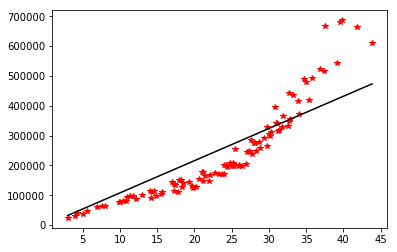

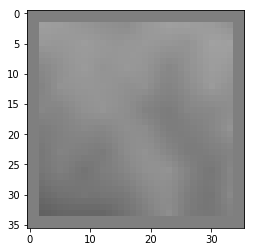

In [19]:
ncp=100
krigeDemsTensor=KrigeDems(dems,ncp)
krigeDemsTensor.data.copy_(((krigeDemsTensor.data-L_ele)/(H_ele-L_ele)-0.5)*2)
imshow(torchvision.utils.make_grid(krigeDemsTensor.data))

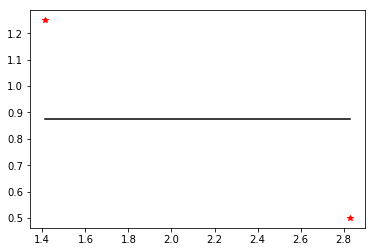

[[ 3.  3.  3.  3.]
 [ 3.  4.  3.  3.]
 [ 3.  3.  2.  3.]
 [ 3.  3.  3.  3.]]


In [20]:
data = np.array([[0, 0, 3],
                 [1, 1, 4],
                 [2, 2, 2]],dtype='f')

gridx = np.arange(0.0, 4.0, 1)
gridy = np.arange(0.0, 4.0, 1)

# Create the ordinary kriging object. Required inputs are the X-coordinates of
# the data points, the Y-coordinates of the data points, and the Z-values of the
# data points. If no variogram model is specified, defaults to a linear variogram
# model.  linear, power, gaussian,spherical, exponential, hole-effect. Default is linear variogram model.
# If no variogram model parameters are specified, then the code automatically
# calculates the parameters by fitting the variogram model to the binned
# experimental semivariogram. The verbose kwarg controls code talk-back, and
# the enable_plotting kwarg controls the display of the semivariogram.
OK = OrdinaryKriging(data[:, 0], data[:, 1], data[:, 2], variogram_model='power',
                     verbose=False, enable_plotting=True,enable_statistics=True,nlags=99999)
# Creates the kriged grid and the variance grid. Allows for kriging on a rectangular
# grid of points, on a masked rectangular grid of points, or wit'h arbitrary points.
# (See OrdinaryKriging.__doc__ for more information.)
z, ss = OK.execute('grid', gridx, gridy)
result=np.zeros((4,4))
for i in gridx:
    for j in gridy:
        result[int(i),int(j)]=z[int(i)][int(j)]
print result
# Writes the kriged grid to an ASCII grid file.
kt.write_asc_grid(gridx, gridy, z, filename="output.asc")

In [ ]:
print d_input
data=(d_input.data.cpu().numpy()/2+0.5)*255
#print data
#np.save('./test_data/1/data.npy',data)
#vutils.save_image(d_input.data[:,:,:,:],'./test_data/1/data.png',padding=0,normalize=True,scale_each=True)

In [ ]:
transform_2=transforms.Compose([     
                                   transforms.Scale(32),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                               ])
dem_data_new = torchvision.datasets.DataLoader(root='./test_data/1/',transform=transform_2)

data_loader_new = torch.utils.data.DataLoader(dem_data_new,
                                          batch_size=1,
                                          shuffle=True)

In [ ]:
dataiter = iter(data_loader_new)
# print dataiter
images, labels = dataiter.next()
batch_s=images.size(0)
print images

dems = torch.FloatTensor(images.size(0), nc, images.size(2),images.size(3))
dems=Variable(dems)
dems=dems.cuda()
dems.data.copy_(images[:,0,:,:])
'''print dems/2.0+0.5'''
imshow(torchvision.utils.make_grid(dems.data))
print dems

cpLayer =torch.FloatTensor(batch_s,nc,dems.size(2),dems.size(3)).zero_()# all ncp control points in one layer
cpLayer=Variable(cpLayer).cuda()
cpLayer.data.copy_(images[:,1,:,:]) # control points vector for all dems in one dems batch
print cpLayer